# Simulating a supernova in LSST

The purpose of this notebook is to produce a simulation of the timeseries photometry that Rubin's LSST could deliver for an example supernova, given the baseline_v4.0 survey strategy that will be adopted for the first years of the survey.  

This notebook is based on a similar simulation written by Anibal Verala for microlensing events, adapted for SNe and documented by Rachel Street. 

Rubin Observatory has built sophisticated open-source simulation software, [rubin_sim](https://github.com/lsst/rubin_sim), which has been used to explore alternative observing strategies in order to optimize the survey design.  

Full installation instructions can be found at the link above. 

In [1]:
import os
import numpy as np
import pandas as pd
import math
import copy
import matplotlib.pyplot as plt
%matplotlib inline
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, Column
#--------------------------------------
import rubin_sim.phot_utils as phot_utils
import rubin_sim.maf as maf
from rubin_sim.phot_utils import signaltonoise, PhotometricParameters
from rubin_sim.data import get_data_dir
from rubin_sim.data import get_baseline
import healpy as hp
#---------------------------------------
from scipy.interpolate import interp1d

## Set-up
Rubin_sim provides a range of information about the Rubin telescope and instrument that we'll need for the simulation, so we'll start by loading the information on the filter bandpasses and their expected throughputs.  

In [2]:
def set_photometric_parameters(exptime, nexp, readnoise=None):
    """
    Load photometric noise properties from the rubin_sim utilities
    """
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [3]:
# Load the LSST filterset and expected throughput in each filter
LSST_BandPass = {}
lsst_filterlist = 'ugrizy'
for f in lsst_filterlist:
    LSST_BandPass[f] = phot_utils.Bandpass()
    # print(os.path.join(get_data_dir(), 'throughputs', 'baseline', f'total_{f}.dat'))
    LSST_BandPass[f].read_throughput(os.path.join(get_data_dir(), 'throughputs', 'baseline', f'total_{f}.dat'))
photParams = set_photometric_parameters(30,1)

## Target information

LSST includes a number of sub-surveys, such as the Wide-Fast-Deep (WFD), Deep Drilling Field (DDFs) and the Galactic Plane survey, all of which have different cadence choices and balance of exposures in different filters.  So before we can figure out what cadence our simulated target will receive, we need to know where it is in the sky.  

In [4]:
# Target coordinates
target = SkyCoord('11:51:01.80', '-28:44:38.48', frame='icrs', unit=(u.hourangle, u.deg))
#target = SkyCoord('20:51:01.80', '-18:44:38.48', frame='icrs', unit=(u.hourangle, u.deg))

Ra = target.ra.deg
Dec = target.dec.deg

print('Target sky location: RA=' + str(Ra) + 'deg, Dec=' + str(Dec))

# Target distance in parsecs, modulus in mag
distance = 22.4e6
distance_modulus = 31.75

# Extinction in that direction [mags]
Av = 0.29

Target sky location: RA=177.7575deg, Dec=-28.744022222222224


/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_33704/2533011413.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


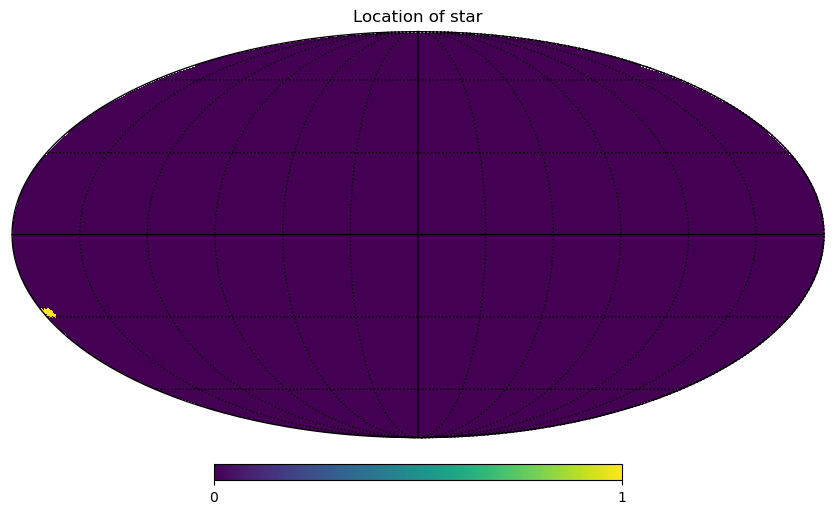

In [5]:
# Plot location on HEALpixel map for comparison with the spatial visit maps
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
phi = np.deg2rad(target.ra.deg)
theta = (np.pi/2.0) - np.deg2rad(target.dec.deg)
radius = max(np.deg2rad(2.0),
             np.deg2rad(hp.max_pixrad(NSIDE,degrees=True)/2.0))
xyz = hp.ang2vec(theta, phi)
pixels = hp.query_disc(NSIDE, xyz, radius)

map = np.zeros(NPIX)
map[pixels] = 1.0

hp.mollview(map, title='Location of star')
hp.graticule()
plt.tight_layout()
#plt.show()
plt.savefig('/Users/rstreet/cassiopeia/GrantProposals/2024/NSF_AAG/Howell_proposal/target_location.png')

For this simulation, we also need an example of the lightcurve shape, which in this case we will load from a text file.

In [6]:
file_path = '/Users/rstreet/cassiopeia/GrantProposals/2024/NSF_AAG/Howell_proposal/41550_2022_1603_MOESM2_ESM.txt'

with open(file_path, 'r') as f:
    file_data = f.readlines()

# Yes, this bit could be coded better.  Deadline's approaching!
# Note we're also converting MJD -> JD here for consistence with Rubin simulations
JD = []
bandpass = []
mag = []
mag_error = [] 
total_error = []
SNR = []
tel = []
for line in file_data:
    if ';' not in line[0:1]:
        entries = line.replace('\n','').split()
        if len(entries) == 7:
            JD.append(float(entries[0])+2400000.0)
            bandpass.append(entries[1])
            mag.append(float(entries[2]))
            mag_error.append(float(entries[3]))
            total_error.append(float(entries[4]))
            SNR.append(float(entries[5]))
            tel.append(entries[6])
        else:
            # It seems to be always the mag_error and SNR that are missing
            JD.append(float(entries[0])+2400000.0)
            bandpass.append(entries[1])
            mag.append(float(entries[2]))
            mag_error.append(-99.999)
            total_error.append(float(entries[3]))
            SNR.append(-99.999)
            tel.append(entries[4])

# For the simulation, we're going to interpolate and generate simulated data, so we'll extract the 
# magnitudes for each filter
target_phot = Table([
    Column(name='JD', data=JD), 
    Column(name='bandpass', data=bandpass), 
    Column(name='mag', data=mag),
])

target_phot

JD,bandpass,mag
float64,str4,float64
2458206.03779,B,21.573
2458206.03913,V,21.257
2458206.11241,B,21.692
2458206.11378,V,20.686
2458206.11528,i,21.224
2458206.17685,B,21.768
...,...,...
2458296.9449,B,16.535
2458296.94627,V,16.091


## LSST Survey Simulation

Next we need the information for the LSST survey strategy.  This is provided by Rubin Project for all the alternative strategy simulations ("opsims") they have explored in the form of a database containing the sequence of exposures and their properties as realised under that particular strategy.  baseline_v4.0 is the opsim database for the latest iteration of the survey strategy, as described in the Phase 3 report from the SCOC.  This is the strategy that Rubin will use for at least the first couple of years.  After that, the real-world performance will be reviewed to ensure the Science Requirements are met.  

In [7]:
# Load the opsim database
baseline_file = '/Users/rstreet/LSST/SCOC/baseline_v4.0_10yrs.db'
name = os.path.basename(baseline_file).replace('.db','')

outDir = 'temp'
resultsDb = maf.db.ResultsDb()

# This section selects which columns from the database will be loaded - in this case, the information on the 
# bandpass and MJD of each exposure, together with the 5sigma limiting magnitude.  
# We provide the target sky location at this point, so that we get the sequence of exposures corresponding to the 
# component survey(s) that cover that location.
bundleList = []
metric = maf.metrics.PassMetric(cols=['filter', 'observationStartMJD', 'fiveSigmaDepth'])
sql = ''
slicer = maf.slicers.UserPointsSlicer(ra=[Ra], dec=[Dec])
bundleList.append(maf.MetricBundle(metric, slicer, sql))

example1_bg = maf.MetricBundleGroup(
    bundleList, baseline_file, out_dir=outDir)
example1_bg.run_all()
dataSlice = bundleList[0].metric_values[0]

# Rubin filterset, and the single-visit limiting magnitude in each of those filters
filters = ['u', 'g', 'r', 'i', 'z', 'y']
mag_limit = {'u': 23.7, 'g': 24.97, 'r': 24.52, 'i': 24.13, 'z': 23.56, 'y': 22.55}

In [8]:
# This section extracts the timestamps of the sequence of exposures into an array  
# for ease of later handling.
print('Total number of visits to this sky location over 10 yrs:')
time_series = {}
for f in filters:
    data = []
    # Observations in the current filter:
    fdx = np.where(dataSlice['filter'] == f)[0]
    print('  ' + f + ' n_visits= ' + str(len(fdx)))
    for i in fdx:
        jd = dataSlice['observationStartMJD'][i] + 2400000.5
        data.append(jd)
    time_series[f] = np.array(data)

Total number of visits to this sky location over 10 yrs:
  u n_visits= 58
  g n_visits= 64
  r n_visits= 183
  i n_visits= 167
  z n_visits= 162
  y n_visits= 152


These figures are consistent with the expectations from the WFD region over the whole survey. 

# Simulated lightcurve

Now we want to resample the input lightcurve based on the simulated LSST cadence.  

In [9]:
# The target photometry table includes data for a range of filters, so we need to separate those into lightcurves. 
filterset = np.unique(target_phot['bandpass'])

# For the purposes of the simulation, we're going to need to adjust the timestamps a little here. 
# Let's offset the timestamps of the lightcurve datapoints so that they fall during the Rubin survey. 
# We need to be careful with this in survey regions (like the WFD) that undergo rolling in different sky regions in different 
# years, as that could heavily influence the cadence.  It's also best to avoid Year 1, since most of it will be dedicated to 
# template acquisition. 
rubin_jd_min = 2460650.6071012997302
rubin_jd_max = 2464616.012582127541
n_year = 3.0
t_offset = rubin_jd_min - target_phot['JD'].min() + n_year*365.24

# At the same time as unpacking the lightcurves, we'll create the 1D interpolation functions for each filter
lightcurves = {}
interp_lc = {}
for f in filterset:
    idx = target_phot['bandpass'] == f
    lc = target_phot[idx]
    lc['JD'] += t_offset
    lightcurves[f] = lc
    interp_lc[f] = interp1d(lc['JD'], target_phot[idx]['mag'])

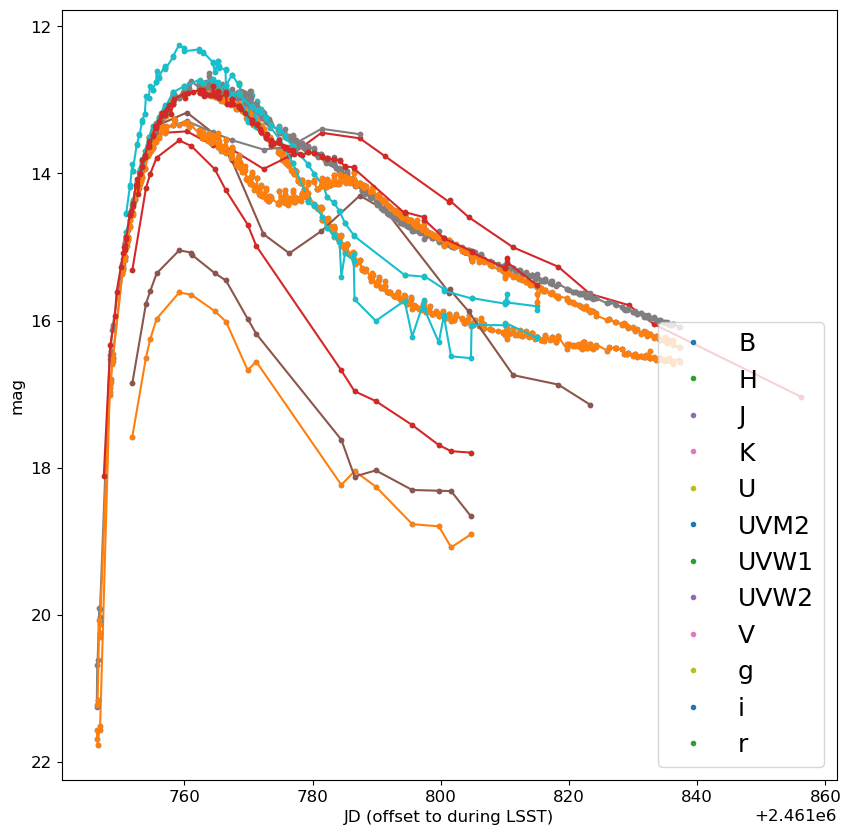

In [11]:
# As a test of the interpolation, here we plot the original data with the interpolation function applied at the same 
# timestamps
fig = plt.figure(1, (10, 10))

for f, lc in lightcurves.items():
    plt.plot(lc['JD'], lc['mag'], marker='.', linestyle=' ', label=f)
    plt.plot(lc['JD'], interp_lc[f](lc['JD']), marker='.', linestyle='-')


plt.rcParams.update({'font.size': 18})
plt.xlabel('JD (offset to during LSST)')
plt.ylabel('mag')
[xmin, xmax, ymin, ymax] = plt.axis()
plt.axis([xmin, xmax, ymax, ymin])
plt.legend(loc='lower right')

plt.show()

OK, the next step is to interpolate these lightcurves at the timestamps of observations realized by Rubin.  At this point, we need to map the filters provided in the input lightcurve to the SDSS set that Rubin uses.  Here I map these _very_ approximately - this should of course be transformed properly.  

The other issue with this lightcurve is that it is too bright for Rubin, which will saturate at around 16 mag.  So for the sake of this simulation, I'm also going to add an "extinction" term to make the target faint enough to observe.  

In [12]:
mag_offset = 2.0

In [13]:
# Input filter: Rubin filter
filter_map = {
    'u': 'U',
    'g': 'g',
    'r': 'r', 
    'i': 'i',
    'z': 'J',
    'y': 'H'
}

In [14]:
sim_lcs = {}
for f, lc in lightcurves.items():
    if f in filter_map.keys():
        print('Simulating ' + f + '-band observations:')
        # Timestamps of all Rubin observations in this filter for 10yrs
        rubin_ts = time_series[filter_map[f]]
        print(' -> Found ' + str(len(rubin_ts)) + ' observations of this location over 10yrs') 
        
        # Extract the set of Rubin observations during this window
        idx = (rubin_ts >= lc['JD'].min()) & (rubin_ts <= lc['JD'].max())
        ts = rubin_ts[idx]
        ts = np.sort(ts, axis=0)
        print(' -> Of these, ' + str(len(np.where(idx)[0])) + ' occurred during the supernova')
        
        # Interpolate the SNe lightcurve to find the magnitude at each timestamp, then use 
        # the Rubin functions to calculate the photometric uncertainties that Rubin 
        # should deliver
        mag = interp_lc[f](ts) + mag_offset
        magerr = signaltonoise.calc_mag_error_m5(mag,  LSST_BandPass[f], mag_limit[f], photParams)[0]

        # Filter out any measurements that are either too bright or too faint for Rubin
        jdx = (mag <= mag_limit[f]) & (mag >= 16.0)
        #jdx = range(0, len(ts), 1)
        print(' -> Of the remaining datapoints, ' + str(len(np.where(jdx)[0])) + ' meet the flux requirements')
        
        new_lc = Table([
            Column(name='JD', data=ts[jdx]),
            Column(name='mag', data=mag[jdx]),
            Column(name='mag_error', data=magerr[jdx])
        ])
        print(' -> Simulated Rubin lightcurve has ' + str(len(new_lc)) + ' datapoints\n')
        
        sim_lcs[f] = new_lc

Simulating g-band observations:
 -> Found 64 observations of this location over 10yrs
 -> Of these, 0 occurred during the supernova
 -> Of the remaining datapoints, 0 meet the flux requirements
 -> Simulated Rubin lightcurve has 0 datapoints

Simulating i-band observations:
 -> Found 167 observations of this location over 10yrs
 -> Of these, 13 occurred during the supernova
 -> Of the remaining datapoints, 13 meet the flux requirements
 -> Simulated Rubin lightcurve has 13 datapoints

Simulating r-band observations:
 -> Found 183 observations of this location over 10yrs
 -> Of these, 2 occurred during the supernova
 -> Of the remaining datapoints, 2 meet the flux requirements
 -> Simulated Rubin lightcurve has 2 datapoints



And now we can plot the simulated lightcurves

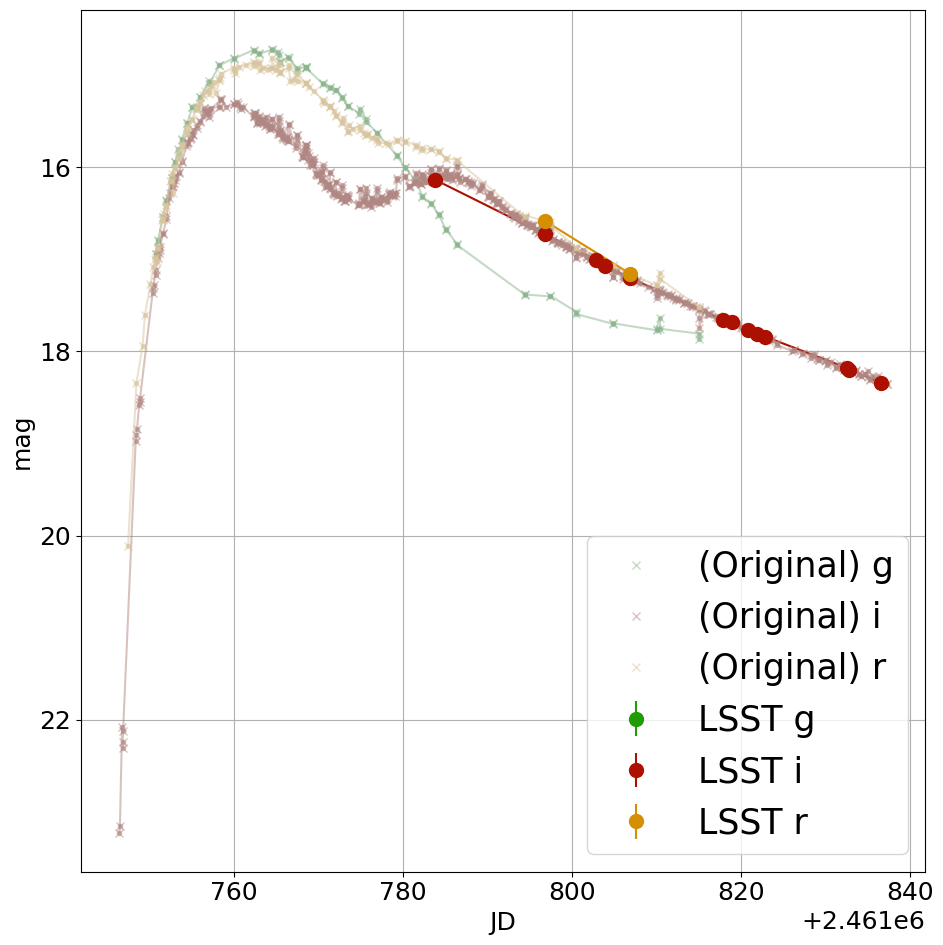

In [15]:
fig = plt.figure(1, (10, 10))

plot_colors = {'g': '#209b01', 'r': '#d58f04', 'i': '#ac1000'}
plot_colors_orig = {'g': '#8bb58d', 'r': '#d8c59e', 'i': '#b18783'}

for f, lc in sim_lcs.items():
    plt.errorbar(
        lc['JD'], lc['mag'], yerr=lc['mag_error'], 
        marker='o', markerfacecolor=plot_colors[f], markeredgecolor=plot_colors[f], markersize=10,
        linestyle=' ', ecolor=plot_colors[f], label='LSST '+f)
    
    if len(lc) > 0:
        plt.plot(lc['JD'], interp_lc[f](lc['JD'])+mag_offset, 
                 marker='.', color=plot_colors[f], 
                 linestyle='-')
        
    orig_lc = lightcurves[f]
    plt.plot(orig_lc['JD'], orig_lc['mag']+mag_offset, marker='x', linestyle=' ', color=plot_colors_orig[f], alpha=0.5, label='(Original) '+f)
    plt.plot(orig_lc['JD'], interp_lc[f](orig_lc['JD'])+mag_offset, marker='.', color=plot_colors_orig[f], alpha=0.5, linestyle='-')
    
plt.rcParams.update({'font.size': 25})
plt.xlabel('JD')
plt.ylabel('mag')
plt.gca().invert_yaxis()
plt.legend()
plt.grid()

#plt.show()
plt.tight_layout()
plt.savefig('/Users/rstreet/cassiopeia/GrantProposals/2024/NSF_AAG/Howell_proposal/lsst_v4_sim_sne.png')